In [1]:
import numpy as np
import cvxpy as cp
from itertools import product
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
def MCWB(c, p_k):
    N = len(p_k[0])
    K = len(p_k)
    
    # Dec Var
    T = [cp.Variable((N, N)) for k in range(K)]
    epsilon = cp.Variable((1, 1))
    p = cp.Variable((N))

    # Obj
    obj = cp.Minimize(epsilon)

    cons = []
    # Cons
    for k in range(K):
        cons.append(T[k] >= 0)
        #cons.append(sum(sum(cp.multiply(T[k], c))) <= epsilon)
        cons.append(cp.trace(c.T@T[k]) <= epsilon)
        cons.append(T[k]@np.ones(N) == p)
        cons.append(T[k].T@np.ones(N) == p_k[k])

    # Solve program
    problem = cp.Problem(obj, cons)
    problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})
    
    return p

In [4]:
def WB(c, p_k, lambdas):
    N = len(p_k[0])
    K = len(p_k)
    
    # Dec Var
    T = [cp.Variable((N, N)) for k in range(K)]
    epsilon = cp.Variable((K, 1))
    p = cp.Variable((N))

    # Obj
    obj = cp.Minimize(epsilon.T@lambdas)

    cons = []
    # Cons
    for k in range(K):
        cons.append(T[k] >= 0)
        #cons.append(sum(sum(cp.multiply(T[k], c))) <= epsilon)
        cons.append(cp.trace(c.T@T[k]) <= epsilon[k])
        cons.append(T[k]@np.ones(N) == p)
        cons.append(T[k].T@np.ones(N) == p_k[k])

    # Solve program
    problem = cp.Problem(obj, cons)
    problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})
    
    return p

In [5]:
# select cifre to analyze
digit = 0

N = 2**8

# Define support for xi
N_euc = int(np.sqrt(N))

# Create cost matrix (l-2 norm used for the moment)
c = np.zeros((N, N))
for i, mi in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
    for j, mj in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
        c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 2)**2 # l-2 norm

In [6]:
# select k
K_list = [2, 5, 10, 15, 20]
p_m = []
p_b = []
p_av = []
for i, K in enumerate(K_list):
    # Save p_k
    p_k = []

    shift = (0, -4) 
    k = np.where(digits.target == digit)[0][0]
    new_digits = np.zeros((16, 16))
    new_digits[4 + int(shift[0]): 12 + int(shift[0]), 4 + int(shift[1]):12 + int(shift[1])] = digits.images[k]
    p_k.append(np.array(new_digits.flatten())/sum(np.array(new_digits.flatten())))
    
    # Loop in number of digits
    for k in np.where(digits.target == digit)[0][1:K]:

        # Create a random shift for each sample
        shift = (0, 4) 

        # Create the new image with the shift in 16x16 pixel array
        new_digits = np.zeros((16, 16))
        new_digits[4 + int(shift[0]): 12 + int(shift[0]), 4 + int(shift[1]):12 + int(shift[1])] = digits.images[k]
        p_k.append(np.array(new_digits.flatten())/sum(np.array(new_digits.flatten())))
        
    p_m.append(MCWB(c, p_k))
    p_b.append(WB(c, p_k, np.ones((K))/K))
    p_av.append(sum(p_k))
    



<Figure size 432x288 with 0 Axes>

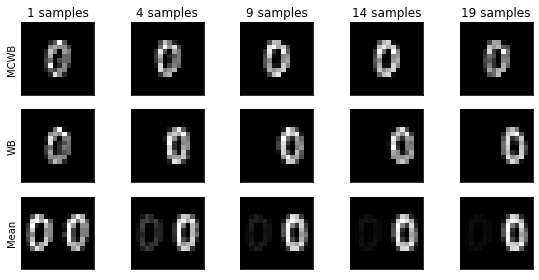

In [21]:
plt.gray()
fig, ax = plt.subplots(3, 5, figsize = (8, 4))

for i, k in enumerate(K_list):
    p_opt_m = p_m[i].value.reshape(N_euc, N_euc)
    p_opt_b = p_b[i].value.reshape(N_euc, N_euc)
    p_opt_av = p_av[i].reshape(N_euc, N_euc)
    ax[0, i].imshow(p_opt_m)
    ax[1, i].imshow(p_opt_b)
    ax[2, i].imshow(p_opt_av)

ax[0, 0].set_ylabel('MCWB')
ax[1, 0].set_ylabel('WB')
ax[2, 0].set_ylabel('Mean')
plt.setp(ax, xticks=[], yticks=[])

for i, k in enumerate(K_list):
    ax[0, i].set_title(str(k - 1) + ' samples')
    
plt.tight_layout()

plt.savefig('poison.pdf')